In [1]:
import learn2learn as l2l
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import sys
import argparse
import os
from run_MAML_04 import test2 as test_maml


sys.path.insert(1, "..")

from ts_dataset import TSDataset
from base_models import LSTMModel, FCN
from metrics import torch_mae as mae
import copy
from pytorchtools import EarlyStopping
from eval_base_models import test, train, freeze_model
from torch.utils.data import Dataset, DataLoader
from ts_dataset import DomainTSDataset, SimpleDataset

## Horizon, Steps HR

In [2]:
meta_info = {"POLLUTION": [5, 50, 14],
             "HR": [32, 50, 13],
             "BATTERY": [20, 50, 3] }




output_directory = "output/"
horizon = 10
output_dim = 1

dataset_name = "HR"
save_model_file = "model6.pt"
load_model_file = "model6.pt"
 #1 adaptation step
experiment_id = "10_COMPARISON_2" #10 adaptation steps


lower_trial = 0
upper_trial = 3
learning_rate = 0.01
meta_learning_rate = 0.005
adaptation_steps = 10
batch_size = 20
model_name = "LSTM"
is_test = 1
patience_stopping = 20
epochs = 1000
noise_level = 0.0
noise_type = "additive"
loss_fn = mae

params = {'batch_size': batch_size,
      'shuffle': True,
      'num_workers': 0}



window_size, task_size, input_dim = meta_info[dataset_name]
grid = [0., noise_level]

train_data = pickle.load(  open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
train_data_ML = pickle.load( open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
validation_data = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
validation_data_ML = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
test_data = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
test_data_ML = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )

In [3]:
trial = 0
learning_rate = 0.01
output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MAML/"+str(trial)+"/"

save_model_file_ = output_directory + "encoder_"+save_model_file
save_model_file_2 = output_directory + save_model_file
load_model_file_ = output_directory + load_model_file


loss_hist_trials_horizon_1 = []
loss_hist_trials_horizon_10 = []
loss_hist_trials_step_1 = []
loss_hist_trials_step_10 = []


experiment_id = "9_COMPARISON_2"

for trial in range(3):

    
    output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MAML/"+str(trial)+"/"
    save_model_file_ = output_directory + experiment_id + "_encoder_model.pt"
    save_model_file_2 = output_directory + experiment_id + "_model.pt"


    model = LSTMModel( batch_size=batch_size, seq_len = window_size, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)
    model2 = nn.Linear(120, 1)

    model.cuda()
    model2.cuda()

    maml = l2l.algorithms.MAML(model2, lr=learning_rate, first_order=False)
    model.load_state_dict(torch.load(save_model_file_))
    maml.load_state_dict(torch.load(save_model_file_2))
    
    print(trial)

    loss_hist_test1 =[]
    for adaptation_steps in range(0,11):
        loss = test_maml(loss_fn, maml, model, model_name, dataset_name, test_data_ML, adaptation_steps, learning_rate,0, noise_type, horizon =1)
        loss_hist_test1.append(float(loss))
        
    loss_hist_test2 =[]
    for horizon in range(1,11):
        loss = test_maml(loss_fn, maml, model, model_name, dataset_name, test_data_ML, 1, learning_rate,0, noise_type, horizon =horizon)
        loss_hist_test2.append(float(loss))

        
    loss_hist_trials_horizon_1.append(loss_hist_test1)
    loss_hist_trials_step_1.append(loss_hist_test2)


experiment_id = "10_COMPARISON_2"

for trial in range(3):

    print(trial)
    output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MAML/"+str(trial)+"/"
    save_model_file_ = output_directory + experiment_id + "_encoder_model.pt"
    save_model_file_2 = output_directory + experiment_id + "_model.pt"


    model = LSTMModel( batch_size=batch_size, seq_len = window_size, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)
    model2 = nn.Linear(120, 1)

    model.cuda()
    model2.cuda()

    maml = l2l.algorithms.MAML(model2, lr=learning_rate, first_order=False)
    model.load_state_dict(torch.load(save_model_file_))
    maml.load_state_dict(torch.load(save_model_file_2))

    loss_hist_test1 =[]
    for adaptation_steps in range(0,11):
        loss = test_maml(loss_fn, maml, model, model_name, dataset_name, test_data_ML, adaptation_steps, learning_rate,0, noise_type, horizon =1)
        loss_hist_test1.append(float(loss))
        
    loss_hist_test2 =[]
    for horizon in range(1,11):
        loss = test_maml(loss_fn, maml, model, model_name, dataset_name, test_data_ML, 10, learning_rate,0, noise_type, horizon =horizon)
        loss_hist_test2.append(float(loss))

        
    loss_hist_trials_horizon_10.append(loss_hist_test1) 
    loss_hist_trials_step_10.append(loss_hist_test2)


0
1
2
0
1
2


In [4]:
np.save( "../../Results/npy_objects/graphs_MAML_horizon_10_"+dataset_name+".npy", loss_hist_trials_horizon_10)
np.save( "../../Results/npy_objects/graphs_MAML_horizon_1_"+dataset_name+".npy", loss_hist_trials_horizon_1)
np.save( "../../Results/npy_objects/graphs_MAML_step_10_"+dataset_name+".npy", loss_hist_trials_step_10)
np.save( "../../Results/npy_objects/graphs_MAML_step_1_"+dataset_name+".npy", loss_hist_trials_step_1)

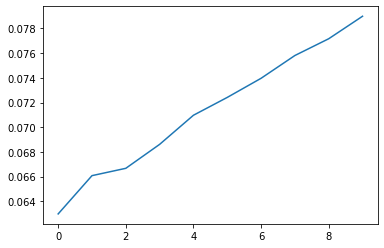

In [5]:
x = np.array(loss_hist_trials_step_1)
m = np.mean(x, axis=0)
plt.plot(m)

Text(0.5, 1.0, 'Horizon 1')

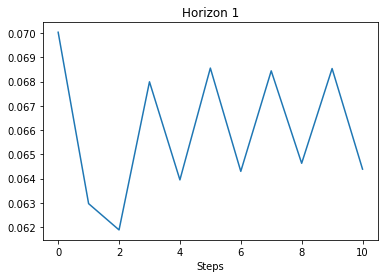

In [6]:
x = np.array(loss_hist_trials_horizon_1)
m = np.mean(x, axis=0)
plt.plot(m)
plt.xlabel("Steps")
plt.title("Horizon 1")


Text(0.5, 1.0, '10 Steps')

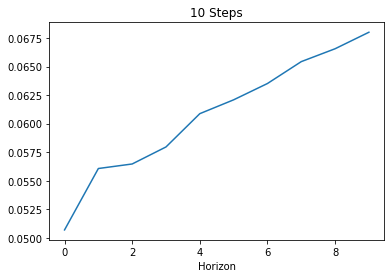

In [7]:
x = np.array(loss_hist_trials_step_10)
m = np.mean(x, axis=0)
plt.plot(m)
plt.xlabel("Horizon")
plt.title("10 Steps")

Text(0.5, 1.0, 'Horizon 10')

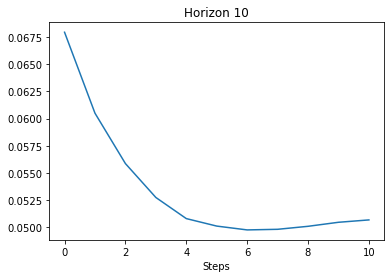

In [8]:
x = np.array(loss_hist_trials_horizon_10)
m = np.mean(x, axis=0)
plt.plot(m)
plt.xlabel("Steps")
plt.title("Horizon 10")

## Horizon, Steps Battery

In [9]:
meta_info = {"POLLUTION": [5, 50, 14],
             "HR": [32, 50, 13],
             "BATTERY": [20, 50, 3] }




output_directory = "output/"
horizon = 10
output_dim = 1

dataset_name = "BATTERY"
save_model_file = "model6.pt"
load_model_file = "model6.pt"
 #1 adaptation step


lower_trial = 0
upper_trial = 3
learning_rate = 0.01
meta_learning_rate = 0.005
adaptation_steps = 10
batch_size = 20
model_name = "LSTM"
is_test = 1
patience_stopping = 20
epochs = 1000
noise_level = 0.0
noise_type = "additive"
loss_fn = mae

params = {'batch_size': batch_size,
      'shuffle': True,
      'num_workers': 0}



window_size, task_size, input_dim = meta_info[dataset_name]
grid = [0., noise_level]

train_data = pickle.load(  open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
train_data_ML = pickle.load( open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
validation_data = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
validation_data_ML = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
test_data = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
test_data_ML = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )

In [10]:
trial = 0
learning_rate = 0.0001
output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MAML/"+str(trial)+"/"

save_model_file_ = output_directory + "encoder_"+save_model_file
save_model_file_2 = output_directory + save_model_file
load_model_file_ = output_directory + load_model_file


loss_hist_trials_horizon_1 = []
loss_hist_trials_horizon_10 = []
loss_hist_trials_step_1 = []
loss_hist_trials_step_10 = []


experiment_id = "17_COMPARISON_1"

for trial in range(3):

    
    output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MAML/"+str(trial)+"/"
    save_model_file_ = output_directory + experiment_id + "_encoder_model.pt"
    save_model_file_2 = output_directory + experiment_id + "_model.pt"


    model = LSTMModel( batch_size=batch_size, seq_len = window_size, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)
    model2 = nn.Linear(120, 1)

    model.cuda()
    model2.cuda()

    maml = l2l.algorithms.MAML(model2, lr=learning_rate, first_order=False)
    model.load_state_dict(torch.load(save_model_file_))
    maml.load_state_dict(torch.load(save_model_file_2))
    
    print(trial)

    loss_hist_test1 =[]
    for adaptation_steps in range(0,11):
        loss = test_maml(loss_fn, maml, model, model_name, dataset_name, test_data_ML, adaptation_steps, learning_rate,0, noise_type, horizon =1)
        loss_hist_test1.append(float(loss))
        
    loss_hist_test2 =[]
    for horizon in range(1,11):
        loss = test_maml(loss_fn, maml, model, model_name, dataset_name, test_data_ML, 1, learning_rate,0, noise_type, horizon =horizon)
        loss_hist_test2.append(float(loss))

        
    loss_hist_trials_horizon_1.append(loss_hist_test1)
    loss_hist_trials_step_1.append(loss_hist_test2)


experiment_id = "18_COMPARISON_1"

for trial in range(3):

    print(trial)
    output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MAML/"+str(trial)+"/"
    save_model_file_ = output_directory + experiment_id + "_encoder_model.pt"
    save_model_file_2 = output_directory + experiment_id + "_model.pt"


    model = LSTMModel( batch_size=batch_size, seq_len = window_size, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)
    model2 = nn.Linear(120, 1)

    model.cuda()
    model2.cuda()

    maml = l2l.algorithms.MAML(model2, lr=learning_rate, first_order=False)
    model.load_state_dict(torch.load(save_model_file_))
    maml.load_state_dict(torch.load(save_model_file_2))

    loss_hist_test1 =[]
    for adaptation_steps in range(0,11):
        loss = test_maml(loss_fn, maml, model, model_name, dataset_name, test_data_ML, adaptation_steps, learning_rate,0, noise_type, horizon =1)
        loss_hist_test1.append(float(loss))
        
    loss_hist_test2 =[]
    for horizon in range(1,11):
        loss = test_maml(loss_fn, maml, model, model_name, dataset_name, test_data_ML, 10, learning_rate,0, noise_type, horizon =horizon)
        loss_hist_test2.append(float(loss))

        
    loss_hist_trials_horizon_10.append(loss_hist_test1) 
    loss_hist_trials_step_10.append(loss_hist_test2)

    

0
1
2
0
1
2


In [11]:
np.save( "../../Results/npy_objects/graphs_MAML_horizon_10_"+dataset_name+".npy", loss_hist_trials_horizon_10)
np.save( "../../Results/npy_objects/graphs_MAML_horizon_1_"+dataset_name+".npy", loss_hist_trials_horizon_1)
np.save( "../../Results/npy_objects/graphs_MAML_step_10_"+dataset_name+".npy", loss_hist_trials_step_10)
np.save( "../../Results/npy_objects/graphs_MAML_step_1_"+dataset_name+".npy", loss_hist_trials_step_1)

Text(0.5, 0, 'Horizon')

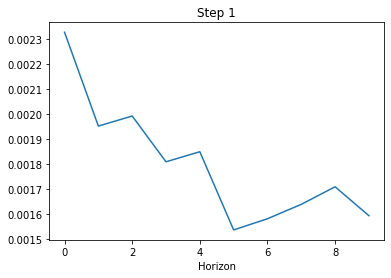

In [12]:
x = np.array(loss_hist_trials_step_1)
m = np.mean(x, axis=0)
plt.plot(m)
plt.title("Step 1")
plt.xlabel("Horizon")

Text(0.5, 1.0, 'Horizon 1')

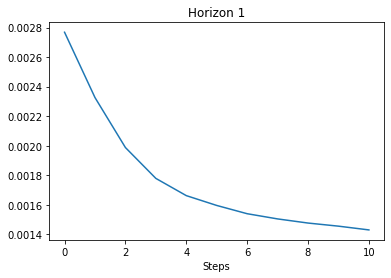

In [13]:
x = np.array(loss_hist_trials_horizon_1)
m = np.mean(x, axis=0)
plt.plot(m)
plt.xlabel("Steps")
plt.title("Horizon 1")


Text(0.5, 1.0, '10 Steps')

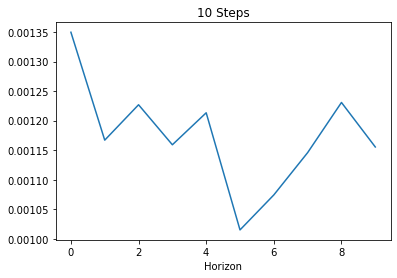

In [14]:
x = np.array(loss_hist_trials_step_10)
m = np.mean(x, axis=0)
plt.plot(m)
plt.xlabel("Horizon")
plt.title("10 Steps")

Text(0.5, 1.0, 'Horizon 10')

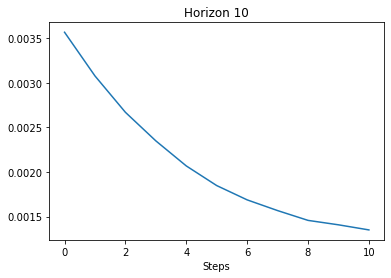

In [15]:
x = np.array(loss_hist_trials_horizon_10)
m = np.mean(x, axis=0)
plt.plot(m)
plt.xlabel("Steps")
plt.title("Horizon 10")

## Horizon, Steps Pollution

In [16]:
meta_info = {"POLLUTION": [5, 50, 14],
             "HR": [32, 50, 13],
             "BATTERY": [20, 50, 3] }




output_directory = "output/"
horizon = 10
output_dim = 1

dataset_name = "POLLUTION"
save_model_file = "model6.pt"
load_model_file = "model6.pt"
 #1 adaptation step


lower_trial = 0
upper_trial = 3
learning_rate = 0.01
meta_learning_rate = 0.005
adaptation_steps = 10
batch_size = 20
model_name = "LSTM"
is_test = 1
patience_stopping = 20
epochs = 1000
noise_level = 0.0
noise_type = "additive"
loss_fn = mae

params = {'batch_size': batch_size,
      'shuffle': True,
      'num_workers': 0}



window_size, task_size, input_dim = meta_info[dataset_name]
grid = [0., noise_level]

train_data = pickle.load(  open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
train_data_ML = pickle.load( open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
validation_data = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
validation_data_ML = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
test_data = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
test_data_ML = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )

In [17]:
trial = 0
learning_rate = 0.01
output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MAML/"+str(trial)+"/"

save_model_file_ = output_directory + "encoder_"+save_model_file
save_model_file_2 = output_directory + save_model_file
load_model_file_ = output_directory + load_model_file


loss_hist_trials_horizon_1 = []
loss_hist_trials_horizon_10 = []
loss_hist_trials_step_1 = []
loss_hist_trials_step_10 = []


experiment_id = "1_COMPARISON_2"

for trial in range(3):

    
    output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MAML/"+str(trial)+"/"
    save_model_file_ = output_directory + experiment_id + "_encoder_model.pt"
    save_model_file_2 = output_directory + experiment_id + "_model.pt"


    model = LSTMModel( batch_size=batch_size, seq_len = window_size, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)
    model2 = nn.Linear(120, 1)

    model.cuda()
    model2.cuda()

    maml = l2l.algorithms.MAML(model2, lr=learning_rate, first_order=False)
    model.load_state_dict(torch.load(save_model_file_))
    maml.load_state_dict(torch.load(save_model_file_2))
    
    print(trial)

    loss_hist_test1 =[]
    for adaptation_steps in range(0,11):
        loss = test_maml(loss_fn, maml, model, model_name, dataset_name, test_data_ML, adaptation_steps, learning_rate,0, noise_type, horizon =1)
        loss_hist_test1.append(float(loss))
        
    loss_hist_test2 =[]
    for horizon in range(1,11):
        loss = test_maml(loss_fn, maml, model, model_name, dataset_name, test_data_ML, 1, learning_rate,0, noise_type, horizon =horizon)
        loss_hist_test2.append(float(loss))

        
    loss_hist_trials_horizon_1.append(loss_hist_test1)
    loss_hist_trials_step_1.append(loss_hist_test2)


learning_rate = 0.001
experiment_id = "2_COMPARISON_2"

for trial in range(3):

    print(trial)
    output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MAML/"+str(trial)+"/"
    save_model_file_ = output_directory + experiment_id + "_encoder_model.pt"
    save_model_file_2 = output_directory + experiment_id + "_model.pt"


    model = LSTMModel( batch_size=batch_size, seq_len = window_size, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)
    model2 = nn.Linear(120, 1)

    model.cuda()
    model2.cuda()

    maml = l2l.algorithms.MAML(model2, lr=learning_rate, first_order=False)
    model.load_state_dict(torch.load(save_model_file_))
    maml.load_state_dict(torch.load(save_model_file_2))

    loss_hist_test1 =[]
    for adaptation_steps in range(0,11):
        loss = test_maml(loss_fn, maml, model, model_name, dataset_name, test_data_ML, adaptation_steps, learning_rate,0, noise_type, horizon =1)
        loss_hist_test1.append(float(loss))
        
    loss_hist_test2 =[]
    for horizon in range(1,11):
        loss = test_maml(loss_fn, maml, model, model_name, dataset_name, test_data_ML, 10, learning_rate,0, noise_type, horizon =horizon)
        loss_hist_test2.append(float(loss))

        
    loss_hist_trials_horizon_10.append(loss_hist_test1) 
    loss_hist_trials_step_10.append(loss_hist_test2)

    

0
1
2
0
1
2


In [18]:
np.save( "../../Results/npy_objects/graphs_MAML_horizon_10_"+dataset_name+".npy", loss_hist_trials_horizon_10)
np.save( "../../Results/npy_objects/graphs_MAML_horizon_1_"+dataset_name+".npy", loss_hist_trials_horizon_1)
np.save( "../../Results/npy_objects/graphs_MAML_step_10_"+dataset_name+".npy", loss_hist_trials_step_10)
np.save( "../../Results/npy_objects/graphs_MAML_step_1_"+dataset_name+".npy", loss_hist_trials_step_1)

Text(0.5, 0, 'Horizon')

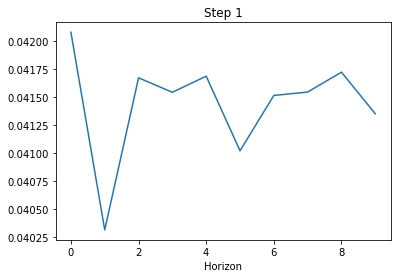

In [19]:
x = np.array(loss_hist_trials_step_1)
m = np.mean(x, axis=0)
plt.plot(m)
plt.title("Step 1")
plt.xlabel("Horizon")

Text(0.5, 1.0, 'Horizon 1')

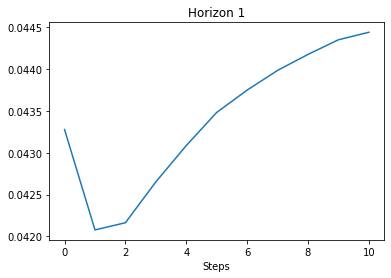

In [20]:
x = np.array(loss_hist_trials_horizon_1)
m = np.mean(x, axis=0)
plt.plot(m)
plt.xlabel("Steps")
plt.title("Horizon 1")


Text(0.5, 1.0, '10 Steps')

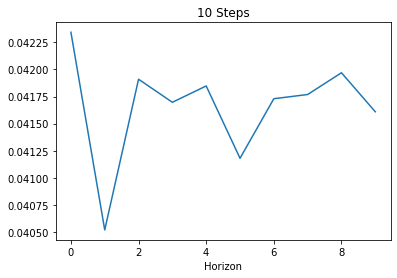

In [21]:
x = np.array(loss_hist_trials_step_10)
m = np.mean(x, axis=0)
plt.plot(m)
plt.xlabel("Horizon")
plt.title("10 Steps")

Text(0.5, 1.0, 'Horizon 10')

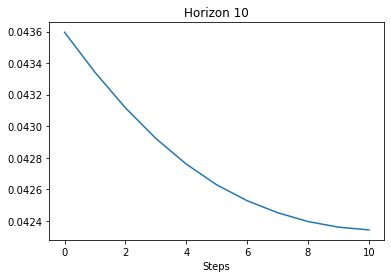

In [22]:
x = np.array(loss_hist_trials_horizon_10)
m = np.mean(x, axis=0)
plt.plot(m)
plt.xlabel("Steps")
plt.title("Horizon 10")